In [ ]:
#### binomial mixture model with variational inference ####

# imports
from scipy.special import comb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
torch.manual_seed(4)

x_train= pd.read_csv(f'/content/gdrive/My Drive/X_data.csv', header=None)
x_train = torch.tensor(x_train.to_numpy())

In [ ]:
##### variational inference implementation ######
def VI_bmm(x_,K=3,iter=500,runs=1):
  n, d = x_.shape
  best_VI=-1e16
  best_LLs=[]

  #initializing priors
  alpha0 = 0.1
  a0 = 0.5
  b0 = 0.5

  for j in range(runs):
    # initializing variational parameters
    a_s = torch.FloatTensor(1,K).uniform_(10, 100)
    b_s = torch.FloatTensor(1,K).uniform_(10, 100)
    alphas = torch.FloatTensor(1,K).uniform_(0,1)

    # initializing log expectations for parameters
    lnpi =torch.digamma(alphas) - torch.digamma(torch.sum(alphas))
    ln_pos_theta = torch.digamma(a_s) -torch.digamma(a_s + b_s)
    ln_neg_theta = torch.digamma(b_s) -torch.digamma(a_s + b_s)
    constant=torch.log(torch.tensor(comb(20, x_)))

    LLs =[]
    for i in range(iter):
      # update q(ci)
      phi =torch.exp(lnpi + x_*ln_pos_theta + (20 -x_)*ln_neg_theta + constant)
      phi = phi/ torch.sum(phi, axis=1)[:,None]

      # update q(pi) q(theta) parameters
      nj= torch.sum(phi, axis=0)
      alphas =alpha0 + nj
      a_s=a0 + torch.sum(phi*x_, axis=0)
      b_s=b0 + torch.sum(phi*(20-x_), axis=0)

      # update log expectations for parameters
      lnpi =torch.digamma(alphas) - torch.digamma(torch.sum(alphas))
      ln_pos_theta = torch.digamma(a_s) -torch.digamma(a_s + b_s)
      ln_neg_theta = torch.digamma(b_s) -torch.digamma(a_s + b_s)

      # variational objective function: evidence lower bound (ELBO)
      VI =-(torch.sum((alphas-1)*lnpi,axis=0) + torch.lgamma(torch.sum(alphas,axis=0)) - torch.sum(torch.lgamma(alphas)) )    -\
        torch.sum(((a_s-1)* ln_pos_theta) + ((b_s-1)* ln_neg_theta) -torch.lgamma(a_s) -torch.lgamma(b_s) +torch.lgamma(a_s +b_s) )+\
        torch.sum((alpha0-1)*lnpi) + ((a0-1)* torch.sum(ln_pos_theta)) + (b0-1)*torch.sum(ln_neg_theta)+\
        torch.sum(phi*lnpi) + torch.sum(phi* (x_*ln_pos_theta + (20 -x_)*ln_neg_theta +constant)) -torch.sum(phi*torch.log(phi))
      LLs+=[VI]
    # saving best run
    if best_VI<VI:
       best_VI=VI
       best_LLs=LLs
       best_phi=phi
  return best_LLs, best_phi

In [ ]:
# binomial mixture model with variational inference
LL3,phi1=VI_bmm(x_train, 3,iter=500,runs=10)
LL9,phi2=VI_bmm(x_train, 9,iter=500,runs=10)
LL15,phi3=VI_bmm(x_train, 15,iter=500,runs=10)

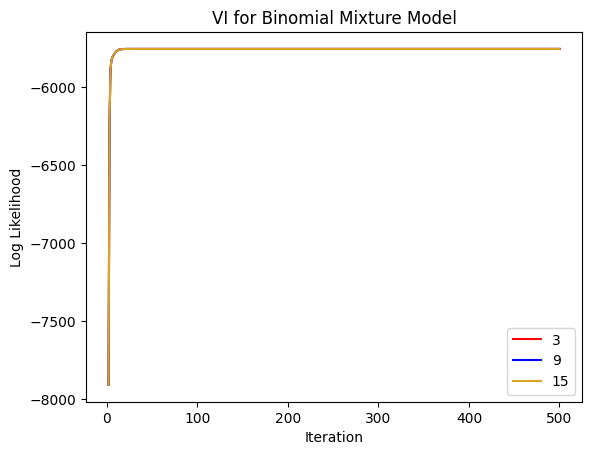

In [ ]:
# plot evidence lower bound (ELBO)
fig =plt.figure()
plt.plot(range(2,501),LL3[1:],color="red",label='3')
plt.plot(range(2,501),LL9[1:],color="blue",label='9')
plt.plot(range(2,501),LL15[1:],color="goldenrod",label='15')
plt.title("VI for Binomial Mixture Model")
plt.ylabel("Log Likelihood")
plt.xlabel("Iteration")
plt.legend()
plt.show()

<Axes: >

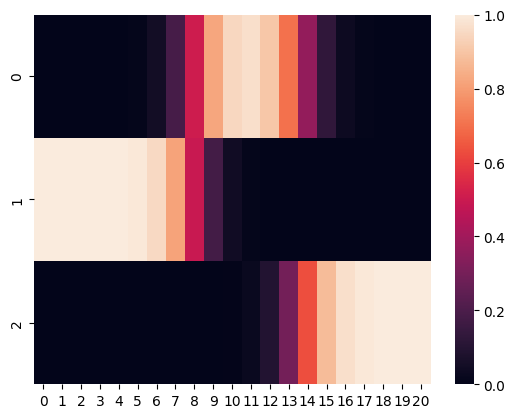

In [ ]:
# examine cluster assignments for x=1...x=20
# K = 3
qs =[]
for x in range (0,21):
  qs+=[phi1[np.where(x_train == x)[0]][-1].numpy()]
result=pd.DataFrame(np.round(np.array(qs).T, 3).tolist())
sns.heatmap(result)

<Axes: >

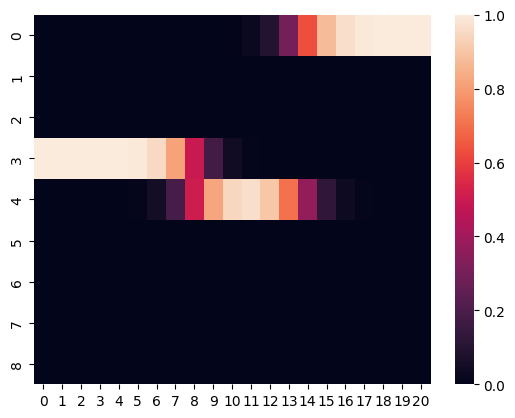

In [ ]:
# K = 9
qs =[]
for x in range (0,21):
  qs+=[phi2[np.where(x_train == x)[0]][-1].numpy()]
result=pd.DataFrame(np.round(np.array(qs).T, 3).tolist())
sns.heatmap(result)

<Axes: >

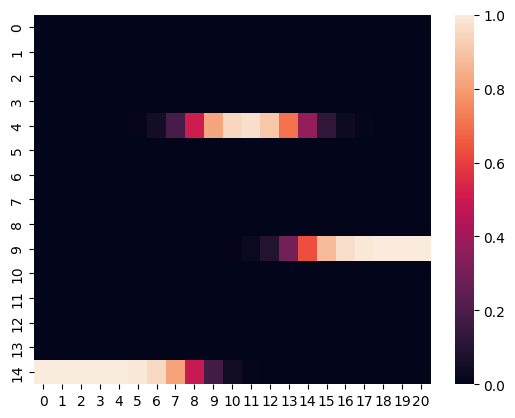

In [ ]:
# K = 15
qs =[]
for x in range (0,21):
  qs+=[phi3[np.where(x_train == x)[0]][-1].numpy()]
result=pd.DataFrame(np.round(np.array(qs).T, 3).tolist())
sns.heatmap(result)